#LOAD DATA

In [3]:
# Loading primary libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# For text processing
import re
from textblob import TextBlob
import gensim
import logging
import tempfile
from gensim import corpora, models, similarities
from sklearn.feature_extraction.text import CountVectorizer


In [4]:
# Dataset reveiws.csv MUST be uploaded to Google Colab before executing this line
df1 = pd.read_csv('climate_change_tweets.csv')

df2 = pd.read_csv('top_climatechange_subreddit_posts.csv')

In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20246 entries, 0 to 20245
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          20246 non-null  object 
 1   content       20246 non-null  object 
 2   id            20246 non-null  float64
 3   replyCount    20246 non-null  int64  
 4   retweetCount  20246 non-null  int64  
 5   likeCount     20246 non-null  int64  
 6   lang          20246 non-null  object 
 7   url           20246 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 1.2+ MB


In [6]:
# Count missing values
missing_count1 = df1.isna().sum()
print("Missing value counts:\n", missing_count1)

Missing value counts:
 date            0
content         0
id              0
replyCount      0
retweetCount    0
likeCount       0
lang            0
url             0
dtype: int64


In [7]:
# Filter the DataFrame to select only English tweets
english_tweets_df = df1[df1['lang'] == 'en']

# Count the total number of English tweets
total_english_tweets = len(english_tweets_df)

# Print the total count of English tweets
print("Total English Tweets:", total_english_tweets)

Total English Tweets: 17906


In [8]:
# Filter the DataFrame to select only English tweets
df1 = df1[df1['lang'] == 'en']

# Reset the index after filtering
df1.reset_index(drop=True, inplace=True)
df1['lang'].unique()

array(['en'], dtype=object)

In [9]:
print('Total records after removing different languages of contents:', df1.shape[0])

Total records after removing different languages of contents: 17906


In [10]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17906 entries, 0 to 17905
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          17906 non-null  object 
 1   content       17906 non-null  object 
 2   id            17906 non-null  float64
 3   replyCount    17906 non-null  int64  
 4   retweetCount  17906 non-null  int64  
 5   likeCount     17906 non-null  int64  
 6   lang          17906 non-null  object 
 7   url           17906 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 1.1+ MB


In [11]:
df1 = df1[['date', 'content']]

In [12]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    200 non-null    int64 
 1   content       200 non-null    object
 2   id            200 non-null    object
 3   replyCount    200 non-null    int64 
 4   retweetCount  200 non-null    int64 
 5   likeCount     200 non-null    int64 
 6   url           200 non-null    object
 7   date_up       200 non-null    object
dtypes: int64(4), object(4)
memory usage: 12.6+ KB


In [13]:
# Count missing values
missing_count2 = df2.isna().sum()
print("Missing value counts:\n", missing_count2)

Missing value counts:
 Unnamed: 0      0
content         0
id              0
replyCount      0
retweetCount    0
likeCount       0
url             0
date_up         0
dtype: int64


In [14]:
df2 = df2[['date_up', 'content']]

In [15]:
# Rename the 'date_up' column in df2 to 'date'
df2.rename(columns={'date_up': 'date'}, inplace=True)

<ipython-input-15-1f3de75b497a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.rename(columns={'date_up': 'date'}, inplace=True)


In [16]:
import pandas as pd

# Concatenate the two DataFrames vertically (stacking them on top of each other)
df = pd.concat([df1, df2], ignore_index=True)
df['date'] = pd.to_datetime(df['date'])
# Save the combined DataFrame to a new CSV file
df.to_csv('combined_file.csv', index=False)

#INFORMATION

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18106 entries, 0 to 18105
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype              
---  ------   --------------  -----              
 0   date     18106 non-null  datetime64[ns, UTC]
 1   content  18106 non-null  object             
dtypes: datetime64[ns, UTC](1), object(1)
memory usage: 283.0+ KB


In [18]:
column_names = df.columns.tolist()
column_names

['date', 'content']

In [19]:
df.head()

,date,content
0,2021-02-27 23:27:21+00:00,@PondSagg #ClimateChange = more #extreme #weat...
1,2021-02-27 15:14:00+00:00,#ClimateChange has harshly impacted #Australia...
2,2021-02-27 12:28:29+00:00,#ClimateCriminal #Australia continues its mass...
3,2021-02-27 12:25:18+00:00,#Australia accused of 'shamefully' holding bac...
4,2021-02-27 12:05:37+00:00,#Australia accused of 'shamefully' holding bac...


#PRELIMINARY ANALYSIS

In [20]:
def word_counter(document):
  split_word = str(document).split(" ") # split by white space
  word_count = len(split_word) # count the words
  return word_count

df['word_count_function'] = df['content'].apply(word_counter)
df.head()

,date,content,word_count_function
0,2021-02-27 23:27:21+00:00,@PondSagg #ClimateChange = more #extreme #weat...,48
1,2021-02-27 15:14:00+00:00,#ClimateChange has harshly impacted #Australia...,18
2,2021-02-27 12:28:29+00:00,#ClimateCriminal #Australia continues its mass...,29
3,2021-02-27 12:25:18+00:00,#Australia accused of 'shamefully' holding bac...,15
4,2021-02-27 12:05:37+00:00,#Australia accused of 'shamefully' holding bac...,15


In [21]:
df['char_count'] = df['content'].str.len()  # Includes the spaces
df.head(5)

,date,content,word_count_function,char_count
0,2021-02-27 23:27:21+00:00,@PondSagg #ClimateChange = more #extreme #weat...,48,294
1,2021-02-27 15:14:00+00:00,#ClimateChange has harshly impacted #Australia...,18,154
2,2021-02-27 12:28:29+00:00,#ClimateCriminal #Australia continues its mass...,29,254
3,2021-02-27 12:25:18+00:00,#Australia accused of 'shamefully' holding bac...,15,152
4,2021-02-27 12:05:37+00:00,#Australia accused of 'shamefully' holding bac...,15,152


In [22]:
def avg_word(sentence):
  words = sentence.split() # split the sentence into words
  avg_of_words = (sum(len(word) for word in words)/len(words))
  return avg_of_words

df['avg_word'] = df['content'].apply(avg_word)
df.head(5)

,date,content,word_count_function,char_count,avg_word
0,2021-02-27 23:27:21+00:00,@PondSagg #ClimateChange = more #extreme #weat...,48,294,5.145833
1,2021-02-27 15:14:00+00:00,#ClimateChange has harshly impacted #Australia...,18,154,7.157895
2,2021-02-27 12:28:29+00:00,#ClimateCriminal #Australia continues its mass...,29,254,7.892857
3,2021-02-27 12:25:18+00:00,#Australia accused of 'shamefully' holding bac...,15,152,8.933333
4,2021-02-27 12:05:37+00:00,#Australia accused of 'shamefully' holding bac...,15,152,8.933333


#TEXT PRE-PROCESSING

## Removing duplicated rows (contents)

In [23]:
# Check duplicate tweets count
duplicate_count = len(df['content'])-len(df['content'].drop_duplicates())
print('Duplicate count:', duplicate_count)
print('Total records before remove duplicates:', df.shape[0])

Duplicate count: 1153
Total records before remove duplicates: 18106


In [24]:
# Drop duplicates (keep the last tweet of each of the duplicates)
df = df.drop_duplicates(subset='content', keep="first")
print('The number of updated records after removing duplicated contents:', df.shape[0])

The number of updated records after removing duplicated contents: 16953


##Lower case

In [25]:
import re

url_pattern = re.compile(r'https?://\S+')

# remove URLs from text
df['content'] = df['content'].apply(lambda x: url_pattern.sub('', x))

print(df)

                           date  \
0     2021-02-27 23:27:21+00:00   
1     2021-02-27 15:14:00+00:00   
2     2021-02-27 12:28:29+00:00   
3     2021-02-27 12:25:18+00:00   
4     2021-02-27 12:05:37+00:00   
...                         ...   
18101 2023-09-03 01:52:53+00:00   
18102 2023-09-01 09:11:19+00:00   
18103 2023-09-01 04:43:36+00:00   
18104 2023-08-31 20:08:40+00:00   
18105 2023-09-01 16:54:54+00:00   

                                                 content  word_count_function  \
0      @PondSagg #ClimateChange = more #extreme #weat...                   48   
1      #ClimateChange has harshly impacted #Australia...                   18   
2      #ClimateCriminal #Australia continues its mass...                   29   
3      #Australia accused of 'shamefully' holding bac...                   15   
4      #Australia accused of 'shamefully' holding bac...                   15   
...                                                  ...                  ...   
18101  Nobel

<ipython-input-25-757d3764e48c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['content'] = df['content'].apply(lambda x: url_pattern.sub('', x))


In [26]:
df['content'] = df['content'].str.lower()
df.head()

<ipython-input-26-deb6f6ba33e6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['content'] = df['content'].str.lower()


,date,content,word_count_function,char_count,avg_word
0,2021-02-27 23:27:21+00:00,@pondsagg #climatechange = more #extreme #weat...,48,294,5.145833
1,2021-02-27 15:14:00+00:00,#climatechange has harshly impacted #australia...,18,154,7.157895
2,2021-02-27 12:28:29+00:00,#climatecriminal #australia continues its mass...,29,254,7.892857
3,2021-02-27 12:25:18+00:00,#australia accused of 'shamefully' holding bac...,15,152,8.933333
4,2021-02-27 12:05:37+00:00,#australia accused of 'shamefully' holding bac...,15,152,8.933333


## Remove symbols

In [27]:
# This regular expression only keeps words and characters
df['content'] = df['content'].str.replace('[^\w\s]','')
df.head()

<ipython-input-27-99a54a56a23a>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['content'] = df['content'].str.replace('[^\w\s]','')


,date,content,word_count_function,char_count,avg_word
0,2021-02-27 23:27:21+00:00,pondsagg climatechange more extreme weather h...,48,294,5.145833
1,2021-02-27 15:14:00+00:00,climatechange has harshly impacted australia ...,18,154,7.157895
2,2021-02-27 12:28:29+00:00,climatecriminal australia continues its mass p...,29,254,7.892857
3,2021-02-27 12:25:18+00:00,australia accused of shamefully holding back g...,15,152,8.933333
4,2021-02-27 12:05:37+00:00,australia accused of shamefully holding back g...,15,152,8.933333


## Remove digits

In [28]:
def remove_digits(sent):
  return " ".join(w for w in sent.split() if not w.isdigit())

df['content'] = df['content'].apply(remove_digits)
df.head()

,date,content,word_count_function,char_count,avg_word
0,2021-02-27 23:27:21+00:00,pondsagg climatechange more extreme weather ho...,48,294,5.145833
1,2021-02-27 15:14:00+00:00,climatechange has harshly impacted australia i...,18,154,7.157895
2,2021-02-27 12:28:29+00:00,climatecriminal australia continues its mass p...,29,254,7.892857
3,2021-02-27 12:25:18+00:00,australia accused of shamefully holding back g...,15,152,8.933333
4,2021-02-27 12:05:37+00:00,australia accused of shamefully holding back g...,15,152,8.933333


## Remove Stopwords

In [29]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

# Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [30]:
df['content'] = df['content'].apply(lambda x: " ".join(x for x in x.split() if x not in stopwordlist))
df.head(5)

,date,content,word_count_function,char_count,avg_word
0,2021-02-27 23:27:21+00:00,pondsagg climatechange extreme weather hot amp...,48,294,5.145833
1,2021-02-27 15:14:00+00:00,climatechange harshly impacted australia integ...,18,154,7.157895
2,2021-02-27 12:28:29+00:00,climatecriminal australia continues mass pollu...,29,254,7.892857
3,2021-02-27 12:25:18+00:00,australia accused shamefully holding back glob...,15,152,8.933333
4,2021-02-27 12:05:37+00:00,australia accused shamefully holding back glob...,15,152,8.933333


In [31]:
df['content'] = df['content'].apply(lambda x: " ".join(x for x in x.split() if x not in emojis))
df.head(5)

,date,content,word_count_function,char_count,avg_word
0,2021-02-27 23:27:21+00:00,pondsagg climatechange extreme weather hot amp...,48,294,5.145833
1,2021-02-27 15:14:00+00:00,climatechange harshly impacted australia integ...,18,154,7.157895
2,2021-02-27 12:28:29+00:00,climatecriminal australia continues mass pollu...,29,254,7.892857
3,2021-02-27 12:25:18+00:00,australia accused shamefully holding back glob...,15,152,8.933333
4,2021-02-27 12:05:37+00:00,australia accused shamefully holding back glob...,15,152,8.933333


## Common and rare word analysis

In [32]:
word_frequency = pd.Series(' '.join(df['content']).split()).value_counts()

In [33]:
# Top common words
word_frequency[:10]  # get top 10

australia        17353
climatechange    16738
climate           4064
amp               2543
auspol            2498
bushfires         1782
australias        1755
change            1688
coal              1536
not               1480
dtype: int64

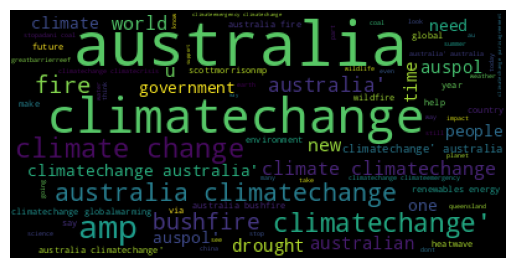

In [34]:
from PIL import Image
from wordcloud import WordCloud

corpus = list(df['content'])

wordcloud = WordCloud(background_color='black', max_words=200, max_font_size=50, random_state=42).generate(str(corpus))

fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [35]:
# least common words
word_frequency[-10:]  # get top 10

29bill            1
fridaysfuture     1
ludovicclement    1
gbnews            1
barber            1
celeste           1
viewfrombehind    1
recycledfabric    1
blending          1
disputing         1
dtype: int64

##Lemmatization

In [36]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [37]:

from nltk.stem import WordNetLemmatizer

lemmtizer = WordNetLemmatizer()

In [38]:
def lemmatize_function(sent):
  word_list = sent.split()
  lemma_word_list = [lemmtizer.lemmatize(word) for word in word_list]
  lemma_Text = " ".join(lemma_word_list)
  return lemma_Text

df['content_lemma'] = df['content'].apply(lemmatize_function)

In [39]:
df[['content','content_lemma']].head(10)

,content,content_lemma
0,pondsagg climatechange extreme weather hot amp...,pondsagg climatechange extreme weather hot amp...
1,climatechange harshly impacted australia integ...,climatechange harshly impacted australia integ...
2,climatecriminal australia continues mass pollu...,climatecriminal australia continues mass pollu...
3,australia accused shamefully holding back glob...,australia accused shamefully holding back glob...
4,australia accused shamefully holding back glob...,australia accused shamefully holding back glob...
5,climatefriday reading ocean currents power wor...,climatefriday reading ocean current power word...
6,australia accused shamefully holding back glob...,australia accused shamefully holding back glob...
7,sadly apparent lacking country efforts address...,sadly apparent lacking country effort address ...
8,post 15c average increase temperature since ap...,post 15c average increase temperature since ap...
9,flying foxeslg bats australias climatechange r...,flying foxeslg bat australia climatechange ref...


#TEXT FEATURE EXTRACTION

##Bigrams

In [40]:
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [41]:
# This function will generate most frequently occuring Bi-grams
def get_ngrams(corpus, ngram_range=(2, 2)):

    # Create CountVectorizer object from sklearn library with bigrams
    vec1 = CountVectorizer(ngram_range=ngram_range, max_features=2000).fit(corpus)

    # Create BoW feature representation using word frequency
    bag_of_words = vec1.transform(corpus)

    # compute sum of words
    sum_words = bag_of_words.sum(axis=0)

    # create (word, frequency) tuples for bigrams
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

In [42]:
bigrams = get_ngrams(df['content'].tolist(), ngram_range=(2, 2))

In [43]:
bigrams_df = pd.DataFrame(bigrams)
bigrams_df.columns=["Bi-gram", "Freq"]

In [44]:
bigrams_df.head()

,Bi-gram,Freq
0,australia climatechange,1526
1,climatechange australia,1405
2,climate change,1403
3,climate climatechange,749
4,climatechange globalwarming,512


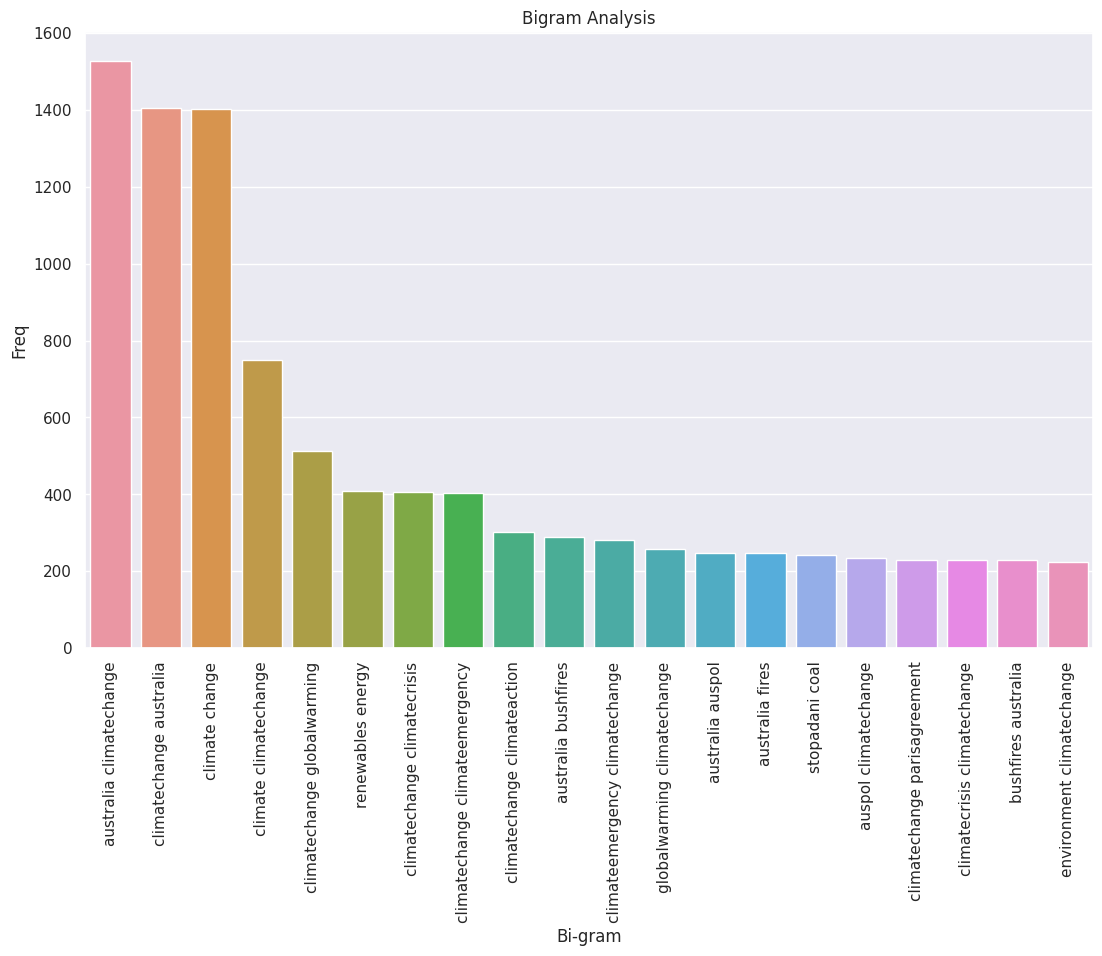

In [45]:
# Barplot of most freq Bi-grams
top_bigrams_to_show = 20

sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=bigrams_df[:top_bigrams_to_show])
h.set_xticklabels(h.get_xticklabels(), rotation=90)  # here rotation parameter shows the angle of your x-axis labels
plt.title('Bigram Analysis')

plt.show()


##Trigrams

In [46]:
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [47]:
# This function will generate most frequently occuring Bi-grams
def get_ngrams(corpus, ngram_range=(3, 3)):

    # Create CountVectorizer object from sklearn library with bigrams
    vec1 = CountVectorizer(ngram_range=ngram_range, max_features=2000).fit(corpus)

    # Create BoW feature representation using word frequency
    bag_of_words = vec1.transform(corpus)

    # compute sum of words
    sum_words = bag_of_words.sum(axis=0)

    # create (word, frequency) tuples for bigrams
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

In [48]:
trigrams = get_ngrams(df['content'].tolist(), ngram_range=(3, 3))

In [49]:
trigrams_df = pd.DataFrame(trigrams)
trigrams_df.columns=["Tri-gram", "Freq"]

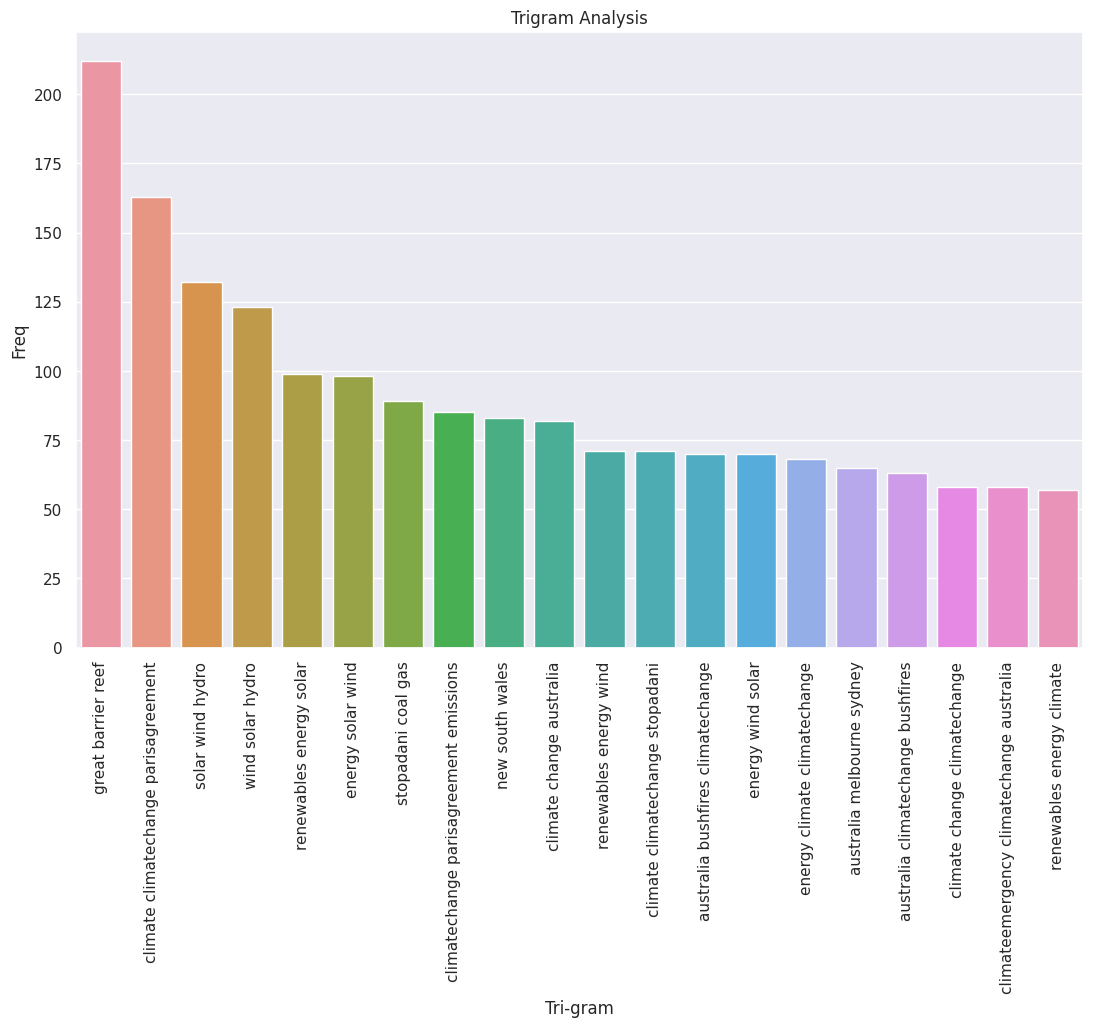

In [50]:
# Barplot of most freq Bi-grams
top_bigrams_to_show = 20

sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Tri-gram", y="Freq", data=trigrams_df[:top_bigrams_to_show])
h.set_xticklabels(h.get_xticklabels(), rotation=90)  # here rotation parameter shows the angle of your x-axis labels
plt.title('Trigram Analysis')
plt.show()

##Bags of words

In [51]:
bow = CountVectorizer(max_features=1000, lowercase=True, ngram_range=(1,1), analyzer = "word")

In [52]:
x_bow = bow.fit_transform(df['content_lemma'])

In [53]:
df['content_lemma'].head()

0    pondsagg climatechange extreme weather hot amp...
1    climatechange harshly impacted australia integ...
2    climatecriminal australia continues mass pollu...
3    australia accused shamefully holding back glob...
4    australia accused shamefully holding back glob...
Name: content_lemma, dtype: object

In [54]:
print(x_bow)

  (0, 176)	1
  (0, 337)	1
  (0, 963)	1
  (0, 456)	1
  (0, 39)	1
  (0, 192)	1
  (0, 630)	1
  (0, 949)	1
  (0, 95)	1
  (0, 65)	1
  (0, 642)	1
  (0, 571)	1
  (0, 236)	1
  (0, 345)	1
  (0, 810)	1
  (0, 172)	1
  (0, 157)	1
  (1, 176)	1
  (1, 65)	2
  (1, 172)	1
  (1, 157)	1
  (1, 292)	1
  (1, 864)	1
  (2, 176)	1
  (2, 65)	2
  :	:
  (16946, 928)	1
  (16946, 288)	1
  (16947, 403)	1
  (16947, 308)	1
  (16947, 443)	1
  (16948, 172)	1
  (16948, 303)	1
  (16948, 785)	1
  (16948, 504)	1
  (16949, 65)	1
  (16949, 976)	1
  (16949, 731)	1
  (16949, 952)	1
  (16950, 172)	1
  (16950, 157)	1
  (16950, 512)	1
  (16950, 631)	1
  (16951, 172)	1
  (16951, 157)	1
  (16951, 323)	1
  (16951, 783)	1
  (16952, 243)	1
  (16952, 878)	2
  (16952, 761)	1
  (16952, 624)	1


##Term frequency - Inverse Document Frequency (TF-IDF)

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

In [56]:
tf_idf = vectorizer.fit_transform(df['content_lemma'])  # as the text data, we will use lemmatized sentences

In [57]:
print(vectorizer.get_feature_names_out())

['000098t' '01000011cs' '010c' ... '𝙡𝙤𝙤𝙠𝙨' '𝙥𝙞𝙘𝙩𝙪𝙧𝙚𝙨' '𝙬𝙝𝙖𝙩']


In [58]:
print(tf_idf[:5])

  (0, 18005)	0.20915786686681512
  (0, 5086)	0.08767109682333453
  (0, 5566)	0.06606976801822749
  (0, 24185)	0.14202070505368608
  (0, 11294)	0.20115988374032345
  (0, 10338)	0.17449894502358157
  (0, 18448)	0.2657814069511307
  (0, 4987)	0.2259853538108219
  (0, 13709)	0.20115988374032345
  (0, 7326)	0.17247820917002185
  (0, 3509)	0.19326212338567397
  (0, 16692)	0.17857758396807252
  (0, 19076)	0.14807909025387148
  (0, 3767)	0.2415374719410095
  (0, 2549)	0.027127297938165602
  (0, 18119)	0.25505329480517464
  (0, 3245)	0.17623456909802113
  (0, 18652)	0.42493906189331343
  (0, 22734)	0.2231976430926128
  (0, 28528)	0.13589600565386445
  (0, 18697)	0.09286689506269473
  (0, 6194)	0.16953531454578366
  (0, 1620)	0.0841183046019661
  (0, 13329)	0.1448768731972262
  (0, 28741)	0.11513220016953278
  :	:
  (2, 5624)	0.038730112567786176
  (3, 5752)	0.19790079944760997
  (3, 5913)	0.27371090697717704
  (3, 962)	0.231100788344045
  (3, 11890)	0.2480175943345627
  (3, 2924)	0.287586304705

#TEMPORAL ANALYSIS

##Date

In [59]:
# Convert the 'date' column to datetime if it's not already
df['date'] = pd.to_datetime(df['date'])

# Split date and time into separate columns
df['date_only'] = df['date'].dt.date
df['time'] = df['date'].dt.time

# Drop the original 'date' column if needed
df.drop(columns=['date'], inplace=True)

print(df)

                                                 content  word_count_function  \
0      pondsagg climatechange extreme weather hot amp...                   48   
1      climatechange harshly impacted australia integ...                   18   
2      climatecriminal australia continues mass pollu...                   29   
3      australia accused shamefully holding back glob...                   15   
4      australia accused shamefully holding back glob...                   15   
...                                                  ...                  ...   
18101  nobel winner joins scientists disputing climat...                    8   
18102                   australias warmest winter record                    5   
18103                        know nothing climate change                    6   
18104  every skeptics argument climate change science...                   12   
18105    day temperatures rise faster night temperatures                    9   

       char_count  avg_word

In [60]:
df_date = df[['date_only','content']]

In [61]:
# Group the twitter datasets based on the date field and get the count per each day.
df_date = df_date.groupby(['date_only'])['content'].count().reset_index(name='tweet_count').set_index('date_only')

print(df_date)

            tweet_count
date_only              
2018-01-01            3
2018-01-02            5
2018-01-03            5
2018-01-04            5
2018-01-05           13
...                 ...
2023-09-20           10
2023-09-21            9
2023-09-22            6
2023-09-23            6
2023-09-24            2

[1173 rows x 1 columns]


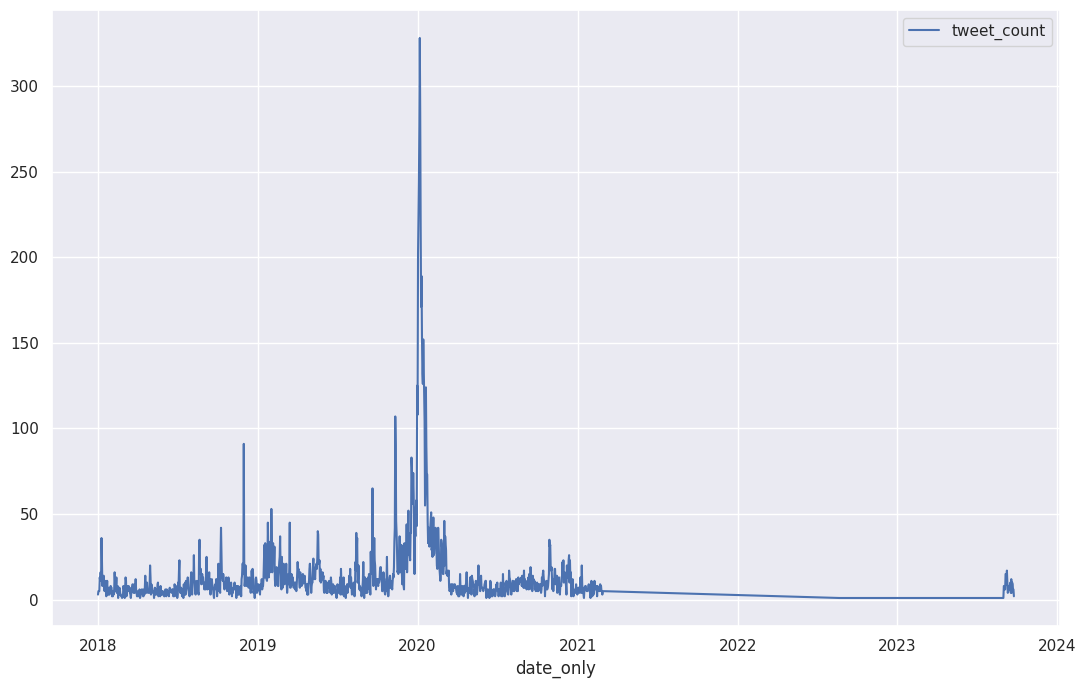

In [62]:
ax = df_date.plot()

plt.savefig('temporal_analysis_date_v2.png', dpi=800)

##Time

In [63]:
df_time = df[['time','content']]

print(df_time)

           time                                            content
0      23:27:21  pondsagg climatechange extreme weather hot amp...
1      15:14:00  climatechange harshly impacted australia integ...
2      12:28:29  climatecriminal australia continues mass pollu...
3      12:25:18  australia accused shamefully holding back glob...
4      12:05:37  australia accused shamefully holding back glob...
...         ...                                                ...
18101  01:52:53  nobel winner joins scientists disputing climat...
18102  09:11:19                   australias warmest winter record
18103  04:43:36                        know nothing climate change
18104  20:08:40  every skeptics argument climate change science...
18105  16:54:54    day temperatures rise faster night temperatures

[16953 rows x 2 columns]


<ipython-input-64-d3901c4e764e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time['time'] = pd.to_datetime(df_time['time'], format='%H:%M:%S')
<ipython-input-64-d3901c4e764e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time['time_bin'] = df_time['time'].apply(lambda x: 'Morning' if x.hour >= 8 and x.hour < 13 else ('Afternoon' if x.hour >= 13 and x.hour < 18 else 'Evening'))


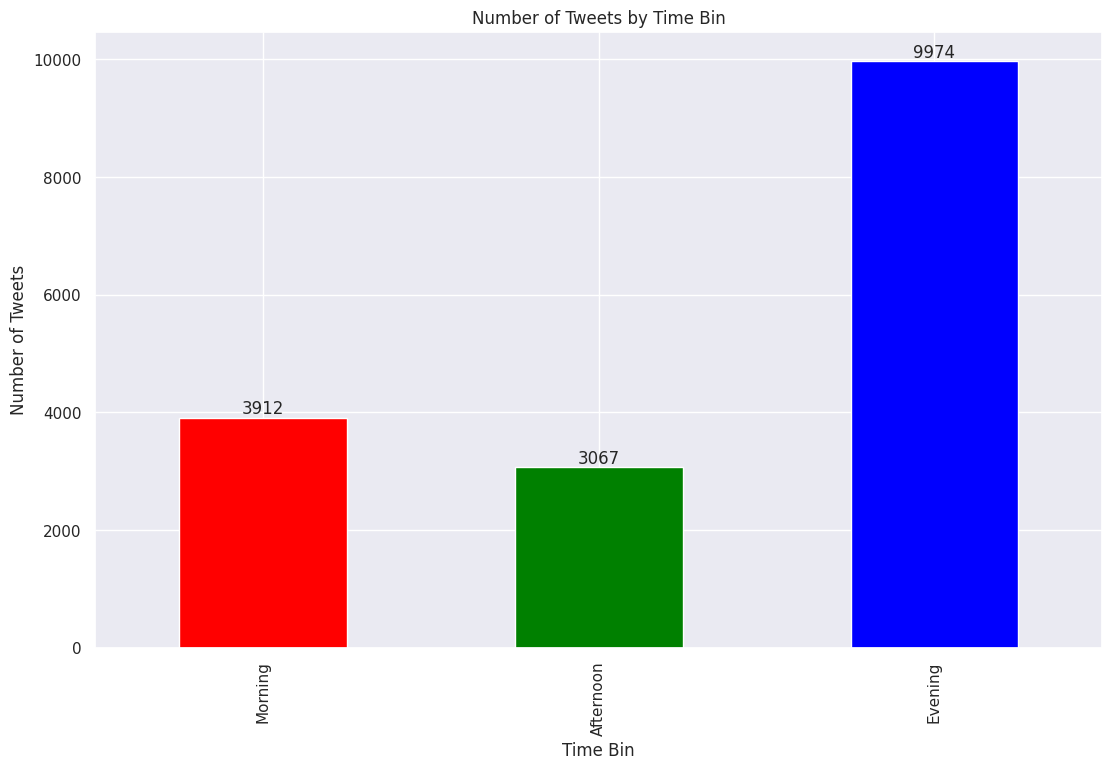

In [64]:
# Convert time column to datetime format
df_time['time'] = pd.to_datetime(df_time['time'], format='%H:%M:%S')

# Create new column with time bin
df_time['time_bin'] = df_time['time'].apply(lambda x: 'Morning' if x.hour >= 8 and x.hour < 13 else ('Afternoon' if x.hour >= 13 and x.hour < 18 else 'Evening'))

# Group tweets by time bin and count number of tweets in each bin
time_bin_counts = df_time.groupby('time_bin')['content'].count()

# Reindex time bin counts in desired order
time_bin_counts = time_bin_counts.reindex(['Morning', 'Afternoon', 'Evening'])

# Plot time bins
time_bin_counts.plot(kind='bar', color=['red', 'green', 'blue'])
plt.xlabel('Time Bin')
plt.ylabel('Number of Tweets')
plt.title('Number of Tweets by Time Bin')
# Add values on top of each bar
for i, v in enumerate(time_bin_counts):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.show()

#SENTIMENT ANALYSIS

##Overall data

In [65]:
df['score'] = df['content_lemma'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [66]:
# Display first 50 tweets with respective score value
print(df[['content_lemma', 'score']][:50])

                                        content_lemma     score
0   pondsagg climatechange extreme weather hot amp...  0.075000
1   climatechange harshly impacted australia integ... -0.200000
2   climatecriminal australia continues mass pollu...  0.000000
3   australia accused shamefully holding back glob...  0.033333
4   australia accused shamefully holding back glob...  0.033333
5   climatefriday reading ocean current power word...  0.142857
6   australia accused shamefully holding back glob...  0.033333
7   sadly apparent lacking country effort address ...  0.093182
8   post 15c average increase temperature since ap... -0.075000
9   flying foxeslg bat australia climatechange ref... -0.062500
10  post 2c average increase temperature since app... -0.075000
11  australia firstplace managing climatechange au...  0.000000
12  australian gdp viewed global soft power rise b...  0.325000
13  making difference role comparative biology tac...  0.100000
14  good morning news today february tig

In [67]:
df['category'] = None

# Convert polarity scores into negative and positive definitions
sentiment = []
for score in df['score']:
    if score < 0:
        sentiment.append("Negative")
    elif score == 0:
        sentiment.append("Neutral")
    else:
        sentiment.append("Positive")
df['sentiment'] = sentiment

In [68]:
print(df[['content_lemma','score','sentiment']][:20])

                                        content_lemma     score sentiment
0   pondsagg climatechange extreme weather hot amp...  0.075000  Positive
1   climatechange harshly impacted australia integ... -0.200000  Negative
2   climatecriminal australia continues mass pollu...  0.000000   Neutral
3   australia accused shamefully holding back glob...  0.033333  Positive
4   australia accused shamefully holding back glob...  0.033333  Positive
5   climatefriday reading ocean current power word...  0.142857  Positive
6   australia accused shamefully holding back glob...  0.033333  Positive
7   sadly apparent lacking country effort address ...  0.093182  Positive
8   post 15c average increase temperature since ap... -0.075000  Negative
9   flying foxeslg bat australia climatechange ref... -0.062500  Negative
10  post 2c average increase temperature since app... -0.075000  Negative
11  australia firstplace managing climatechange au...  0.000000   Neutral
12  australian gdp viewed global soft 

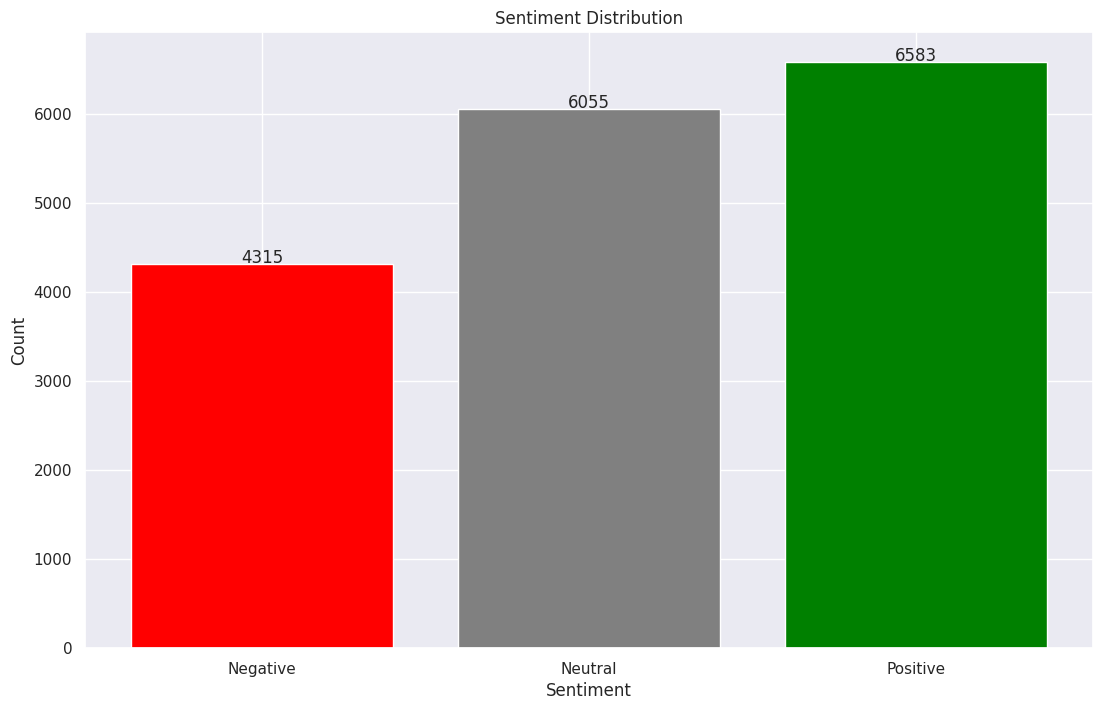

In [69]:
# Group the data by sentiment and count the number of entries in each group
sentiment_counts = df.groupby(['sentiment']).count()['content']

# Define colors for each sentiment category
colors = {'Negative': 'red', 'Neutral': 'gray', 'Positive': 'green'}

# Create a bar plot
fig, ax = plt.subplots()
for sentiment, count in sentiment_counts.items():
    ax.bar(sentiment, count, color=colors[sentiment], label=sentiment)
    ax.text(sentiment, count+5, str(count), ha='center')

ax.set_title('Sentiment Distribution')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Count')
plt.show()

##Date Only

In [70]:
df_date = df[['date_only','content', 'content_lemma']]
df_date['score'] = df_date['content_lemma'].apply(lambda x: TextBlob(x).sentiment.polarity)

<ipython-input-70-ef17331de3d1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_date['score'] = df_date['content_lemma'].apply(lambda x: TextBlob(x).sentiment.polarity)


In [71]:
df_date.groupby(['date_only'])['score'].mean()

date_only
2018-01-01    0.166667
2018-01-02    0.013333
2018-01-03    0.080000
2018-01-04   -0.006634
2018-01-05    0.013462
                ...   
2023-09-20    0.082500
2023-09-21    0.019024
2023-09-22   -0.091667
2023-09-23   -0.133333
2023-09-24   -0.131250
Name: score, Length: 1173, dtype: float64

In [72]:
df_date = df_date.groupby(['date_only'])['score'].mean().reset_index(name='mean_score').set_index('date_only')


In [73]:
df_date

,mean_score
date_only,
2018-01-01,0.166667
2018-01-02,0.013333
2018-01-03,0.080000
2018-01-04,-0.006634
2018-01-05,0.013462
...,...
2023-09-20,0.082500
2023-09-21,0.019024
2023-09-22,-0.091667


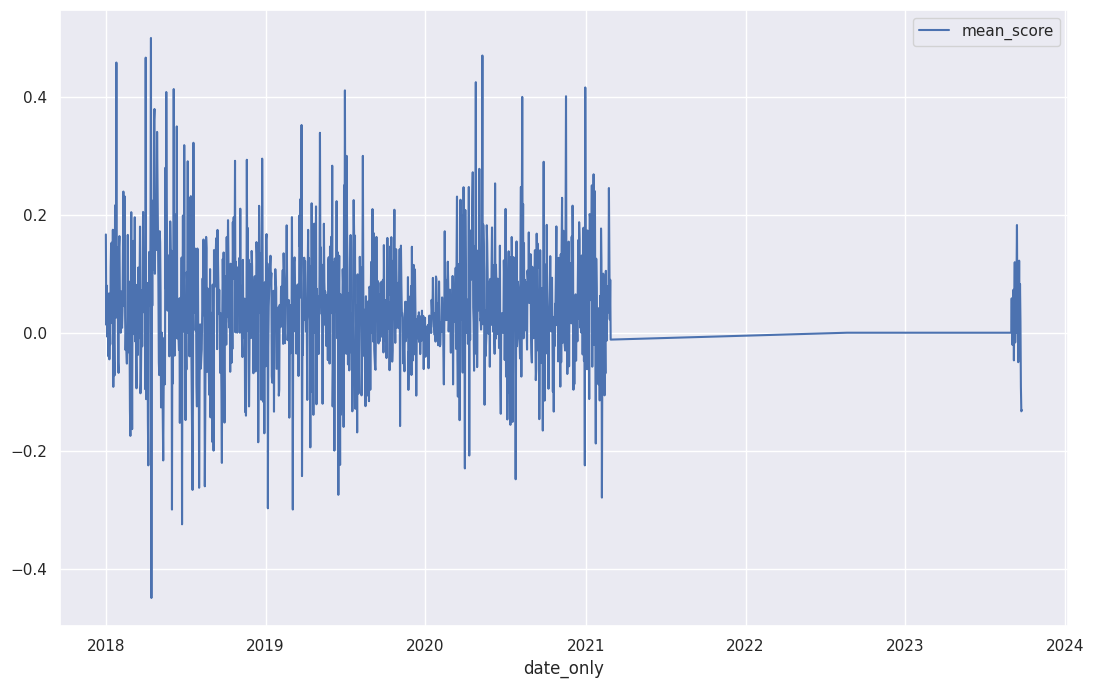

In [74]:
# Plot twitter sentimet timeline over each provider
ax = df_date.plot()
plt.savefig('temporal_score_v2.png', dpi=800)

#TEXT CLASSIFICATION

##Logistic Regression

In [75]:
df['category'] = None

# Convert polarity scores into negative and positive definitions
labels = []
for score in df['score']:
    if score < 0:
        labels.append(0)
    else:
        labels.append(1)

df['labels'] = labels

In [106]:
df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,content,word_count_function,char_count,avg_word,content_lemma,date_only,time,score,category,sentiment,labels
0,pondsagg climatechange extreme weather hot amp...,48,294,5.145833,pondsagg climatechange extreme weather hot amp...,2021-02-27,23:27:21,0.075000,None,Positive,1
1,climatechange harshly impacted australia integ...,18,154,7.157895,climatechange harshly impacted australia integ...,2021-02-27,15:14:00,-0.200000,None,Negative,0
2,climatecriminal australia continues mass pollu...,29,254,7.892857,climatecriminal australia continues mass pollu...,2021-02-27,12:28:29,0.000000,None,Neutral,1
3,australia accused shamefully holding back glob...,15,152,8.933333,australia accused shamefully holding back glob...,2021-02-27,12:25:18,0.033333,None,Positive,1
4,australia accused shamefully holding back glob...,15,152,8.933333,australia accused shamefully holding back glob...,2021-02-27,12:05:37,0.033333,None,Positive,1
...,...,...,...,...,...,...,...,...,...,...,...
18101,nobel winner joins scientists disputing climat...,8,65,7.250000,nobel winner join scientist disputing climate ...,2023-09-03,01:52:53,0.000000,None,Neutral,1
18102,australias warmest winter record,5,36,6.400000,australia warmest winter record,2023-09-01,09:11:19,0.000000,None,Neutral,1
18103,know nothing climate change,6,35,5.000000,know nothing climate change,2023-09-01,04:43:36,0.000000,None,Neutral,1
18104,every skeptics argument climate change science...,12,72,5.083333,every skeptic argument climate change science ...,2023-08-31,20:08:40,0.000000,None,Neutral,1


In [76]:
from sklearn.model_selection import train_test_split

sentences_train, sentences_test, y_train, y_test = train_test_split(df['content_lemma'], df['labels'], test_size=0.33, random_state=2)

In [77]:
from sklearn.feature_extraction.text import CountVectorizer

In [78]:
bow = CountVectorizer(min_df=0, lowercase=False)
bow.fit(sentences_train)

CountVectorizer(lowercase=False, min_df=0)

In [79]:
X_train = bow.transform(sentences_train)
X_test  = bow.transform(sentences_test)

In [80]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [81]:
score_train = classifier.score(X_train, y_train)
score_test = classifier.score(X_test, y_test)
print('Train accuracy: {:.2f}%'.format(score_train*100))
print('Test accuracy: {:.2f}%'.format(score_test*100))

Train accuracy: 98.83%
Test accuracy: 88.78%


In [82]:
testing = "The climate has had some significant improvement thanks to the strict rules and regulations of governments."

In [83]:
testing = "The street is very dirty"

In [84]:
vector_representation = bow.transform([testing])
prediction = classifier.predict(vector_representation)[0]

if prediction > 0:
   print("Positive Review")
else:
   print("Negative Review")

Negative Review


#TOPIC MODELING

In [85]:
# Setting up the environment for LDA algorithm.

TEMP_FOLDER = tempfile.gettempdir()
print('Folder "{}" will be used to save temporary dictionary and corpus.'.format(TEMP_FOLDER))
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Folder "/tmp" will be used to save temporary dictionary and corpus.


In [86]:
# Convert the tweets as the text corpus.
corpus = list(df['content_lemma'])

In [87]:
corpus[:5]

['pondsagg climatechange extreme weather hot amp cold not want roast nor beautiful nativeanimals australia nor blown off map bigger cyclone ignorant celebrate niagra fall freezing sign climate change myth',
 'climatechange harshly impacted australia integral ecology core australia committment tackle climate change',
 'climatecriminal australia continues mass pollution planet backlash coming wait international boycott against australia holding olympicgames auspol climatechange extinctionrebellion',
 'australia accused shamefully holding back global action climate change climatestrike climatechange climatecrisis',
 'australia accused shamefully holding back global action climate change climatestrike climatechange climatecrisis']

In [88]:
# Tokenization
Text = [[word for word in str(document).split()] for document in corpus]

In [89]:
Text[:5]

[['pondsagg',
  'climatechange',
  'extreme',
  'weather',
  'hot',
  'amp',
  'cold',
  'not',
  'want',
  'roast',
  'nor',
  'beautiful',
  'nativeanimals',
  'australia',
  'nor',
  'blown',
  'off',
  'map',
  'bigger',
  'cyclone',
  'ignorant',
  'celebrate',
  'niagra',
  'fall',
  'freezing',
  'sign',
  'climate',
  'change',
  'myth'],
 ['climatechange',
  'harshly',
  'impacted',
  'australia',
  'integral',
  'ecology',
  'core',
  'australia',
  'committment',
  'tackle',
  'climate',
  'change'],
 ['climatecriminal',
  'australia',
  'continues',
  'mass',
  'pollution',
  'planet',
  'backlash',
  'coming',
  'wait',
  'international',
  'boycott',
  'against',
  'australia',
  'holding',
  'olympicgames',
  'auspol',
  'climatechange',
  'extinctionrebellion'],
 ['australia',
  'accused',
  'shamefully',
  'holding',
  'back',
  'global',
  'action',
  'climate',
  'change',
  'climatestrike',
  'climatechange',
  'climatecrisis'],
 ['australia',
  'accused',
  'shamef

In [90]:
# Create a dictionary based on the tokanized words of all the tweets.
dictionary = corpora.Dictionary(Text)

# Save the above dictionary as a local file for LDA model to access.
dictionary.save(os.path.join(TEMP_FOLDER, 'dict'))

When creating the dictionary, each tweet (document) is alphabetically sorted before composing the dictionary.

In [91]:
print(Text[0])
print('alphabetically sorted', sorted(Text[0]))

['pondsagg', 'climatechange', 'extreme', 'weather', 'hot', 'amp', 'cold', 'not', 'want', 'roast', 'nor', 'beautiful', 'nativeanimals', 'australia', 'nor', 'blown', 'off', 'map', 'bigger', 'cyclone', 'ignorant', 'celebrate', 'niagra', 'fall', 'freezing', 'sign', 'climate', 'change', 'myth']
alphabetically sorted ['amp', 'australia', 'beautiful', 'bigger', 'blown', 'celebrate', 'change', 'climate', 'climatechange', 'cold', 'cyclone', 'extreme', 'fall', 'freezing', 'hot', 'ignorant', 'map', 'myth', 'nativeanimals', 'niagra', 'nor', 'nor', 'not', 'off', 'pondsagg', 'roast', 'sign', 'want', 'weather']


In [92]:
print(Text[1])
print('alphabetically sorted', sorted(Text[1]))

['climatechange', 'harshly', 'impacted', 'australia', 'integral', 'ecology', 'core', 'australia', 'committment', 'tackle', 'climate', 'change']
alphabetically sorted ['australia', 'australia', 'change', 'climate', 'climatechange', 'committment', 'core', 'ecology', 'harshly', 'impacted', 'integral', 'tackle']


In [93]:
# Print the dictionary
print(dictionary.token2id)

{'amp': 0, 'australia': 1, 'beautiful': 2, 'bigger': 3, 'blown': 4, 'celebrate': 5, 'change': 6, 'climate': 7, 'climatechange': 8, 'cold': 9, 'cyclone': 10, 'extreme': 11, 'fall': 12, 'freezing': 13, 'hot': 14, 'ignorant': 15, 'map': 16, 'myth': 17, 'nativeanimals': 18, 'niagra': 19, 'nor': 20, 'not': 21, 'off': 22, 'pondsagg': 23, 'roast': 24, 'sign': 25, 'want': 26, 'weather': 27, 'committment': 28, 'core': 29, 'ecology': 30, 'harshly': 31, 'impacted': 32, 'integral': 33, 'tackle': 34, 'against': 35, 'auspol': 36, 'backlash': 37, 'boycott': 38, 'climatecriminal': 39, 'coming': 40, 'continues': 41, 'extinctionrebellion': 42, 'holding': 43, 'international': 44, 'mass': 45, 'olympicgames': 46, 'planet': 47, 'pollution': 48, 'wait': 49, 'accused': 50, 'action': 51, 'back': 52, 'climatecrisis': 53, 'climatestrike': 54, 'global': 55, 'shamefully': 56, 'climatefriday': 57, 'climateguyw': 58, 'current': 59, 'day': 60, 'diary': 61, 'ecosystem': 62, 'extremetemperature': 63, 'extremeweather': 

In [94]:
# Convert the text dictionary to bag of words model
corpus = [dictionary.doc2bow(text) for text in Text]

In [95]:
tweet_id = 0
print(Text[tweet_id]) # each tweet converted to tokens
print(dictionary.doc2bow(Text[tweet_id])) # each token is represented as a id from a dictionary

['pondsagg', 'climatechange', 'extreme', 'weather', 'hot', 'amp', 'cold', 'not', 'want', 'roast', 'nor', 'beautiful', 'nativeanimals', 'australia', 'nor', 'blown', 'off', 'map', 'bigger', 'cyclone', 'ignorant', 'celebrate', 'niagra', 'fall', 'freezing', 'sign', 'climate', 'change', 'myth']
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 2), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1)]


##Generate the topic model

In [96]:
# Construct TF-IDF features from the dictionary.
tfidf = models.TfidfModel(corpus)

In [97]:
# Transform the tweets as TF-IDF feature vectors
corpus_tfidf = tfidf[corpus]

In [98]:
total_topics = 40

In [99]:
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi

In [100]:
# Print the Keyword in the 10 topics
lda.show_topics(total_topics, num_words=6)

[(0,
  '0.044*"climatechange" + 0.042*"adani" + 0.042*"australia" + 0.026*"water" + 0.019*"coal" + 0.016*"kill"'),
 (1,
  '0.068*"climatechange" + 0.064*"australia" + 0.029*"auspol" + 0.024*"amp" + 0.016*"au" + 0.015*"scottmorrisonmp"'),
 (2,
  '0.079*"australia" + 0.071*"climatechange" + 0.037*"wildlife" + 0.027*"environment" + 0.024*"ecosystem" + 0.021*"help"'),
 (3,
  '0.046*"rain" + 0.040*"smoke" + 0.039*"sydney" + 0.039*"october" + 0.035*"mass" + 0.035*"catastrophic"'),
 (4,
  '0.063*"australia" + 0.058*"climatechange" + 0.026*"mine" + 0.024*"renewableenergy" + 0.022*"coal" + 0.020*"cleanenergy"'),
 (5,
  '0.105*"australia" + 0.086*"climatechange" + 0.043*"record" + 0.036*"heat" + 0.033*"heatwave" + 0.025*"climate"'),
 (6,
  '0.065*"australia" + 0.056*"climatechange" + 0.029*"fire" + 0.019*"hundred" + 0.015*"increasing" + 0.013*"megacoal"'),
 (7,
  '0.060*"australia" + 0.058*"climatechange" + 0.024*"getting" + 0.021*"turtle" + 0.018*"ipcc" + 0.017*"least"'),
 (8,
  '0.062*"photo" 

##Interactive topic analyzer

In [101]:
!pip install pyLDAvis==3.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 27.7 MB/s eta 0:00:00


In [102]:
import pyLDAvis.gensim_models

In [103]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim_models.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pyLDAvis/_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x          y  topics  cluster       Freq
topic                                                 
32     2.215227 -11.793689       1        1  17.324469
24     2.327033 -10.962135       2        1   7.320117
23     2.422806 -11.193618       3        1   5.666259
25     2.102879 -11.139439       4        1   4.547977
36     2.112326 -11.574103       5        1   3.715494
16     1.672376 -11.728271       6        1   3.485558
27     1.707201 -10.518386       7        1   3.178793
14     2.538555 -11.383177       8        1   2.664536
13     1.831340 -13.318464       9        1   2.210746
11     2.220854 -12.408849      10        1   2.020796
33     1.608692 -12.406289      11        1   1.965927
30     0.913305 -11.267883      12        1   1.697660
4      1.565788 -11.463218      13        1   1.670321
5      2.536175 -10.919423      14        1   1.659656
2      2.609548 -10.933206      15        1   1.635877
18     2.178485 -11.818938      16        1   1.621028
1      2.325877 -11.578843      17        1   1.606800
7      2.792722 -11.565758      18        1   1.581985
26     2.196843 -12.680223      19        1   1.581386
20     2.401046 -11.571979      20        1   1.564029
38     2.774175 -10.905191      21        1   1.564029
37     2.290929 -11.095153      22        1   1.564029
31     3.233816 -11.949382      23        1   1.564029
34     2.302977 -10.052002      24        1   1.564029
29     2.069112 -11.503265      25        1   1.564029
28     2.170142 -11.255583      26        1   1.564029
35     1.254203 -11.620461      27        1   1.564029
0      1.574900 -11.335063      28        1   1.564029
22     3.163440 -11.191106      29        1   1.564029
21     2.494929 -12.066292      30        1   1.564029
19     1.348298 -12.771191      31        1   1.564029
17     1.900307 -13.147911      32        1   1.564029
15     1.576175 -11.773924      33        1   1.564029
12     2.900458 -11.180992      34        1   1.564029
10     2.565202 -12.392454      35        1   1.564029
9      3.112806 -11.558425      36        1   1.564029
8      1.861063 -13.224353      37        1   1.564029
6      2.343328 -10.957426      38        1   1.564029
3      2.086513 -13.345376      39        1   1.564029
39     2.924270 -10.729792      40        1   1.564029, topic_info=                Term        Freq       Total Category  logprob  loglift
1          australia  756.000000  756.000000  Default  30.0000  30.0000
8      climatechange  705.000000  705.000000  Default  29.0000  29.0000
118          drought   84.000000   84.000000  Default  28.0000  28.0000
7            climate  165.000000  165.000000  Default  27.0000  27.0000
6             change  102.000000  102.000000  Default  26.0000  26.0000
..               ...         ...         ...      ...      ...      ...
85               new    1.897762   38.807731  Topic40  -4.6906   1.1400
7            climate    2.314803  165.461065  Topic40  -4.4919  -0.1115
693   sustainability    1.664053   15.248450  Topic40  -4.8220   1.9427
494              usa    1.491161   12.423530  Topic40  -4.9317   2.0379
266  renewableenergy    1.482866   18.666132  Topic40  -4.9373   1.6252

[2267 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
445      19  1.084665          4c
1216      1  0.422033         abc
1216     30  0.422033         abc
665      19  0.682117      abc730
1593      6  0.609598     abcnews
...     ...       ...         ...
444       3  0.245261     youtube
444      27  0.490523     youtube
909      10  1.231464         yyc
2982     40  1.234118     zealand
2968     15  0.867927  zerocarbon

[3334 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[33, 25, 24, 26, 37, 17, 28, 15, 14, 12, 34, 31, 5, 6, 3, 19, 2, 8, 27, 21, 39, 38, 32, 35, 30, 29, 36, 1, 23, 22, 20, 18, 16, 13, 11, 10, 9, 7, 4, 40])

In [104]:
df.to_csv('final_data.csv', index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [105]:
print(df)

                                                 content  word_count_function  \
0      pondsagg climatechange extreme weather hot amp...                   48   
1      climatechange harshly impacted australia integ...                   18   
2      climatecriminal australia continues mass pollu...                   29   
3      australia accused shamefully holding back glob...                   15   
4      australia accused shamefully holding back glob...                   15   
...                                                  ...                  ...   
18101  nobel winner joins scientists disputing climat...                    8   
18102                   australias warmest winter record                    5   
18103                        know nothing climate change                    6   
18104  every skeptics argument climate change science...                   12   
18105    day temperatures rise faster night temperatures                    9   

       char_count  avg_word

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
